### Import Libraries

In [1]:
# Import the import_ipynb library to enable importing Jupyter notebooks as modules
import import_ipynb

# Import custom Tennis Analysis Tools module
import Tennis_Analysis_Tools as tennis_tools

# Import necessary libraries
import numpy as np                   # For numerical operations
import pandas as pd                  # For data manipulation and analysis
import matplotlib.pyplot as plt      # For data visualization
from sklearn.preprocessing import OneHotEncoder  # For one-hot encoding categorical data

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from Tennis_Analysis_Tools.ipynb


### Function to preprocess the dataset

In [2]:
def preprocess_dataset(betting_data_dfs):
    
    """
    Preprocess the betting dataset to prepare it for analysis.

    This function filters the dataset to include only completed matches,
    fills NaN values in ranking columns with 100000 (representing unranked players),
    converts rankings to numeric values, creates a column indicating if the 
    higher-ranked player won, calculates the sets difference, keeps only the 
    essential columns for analysis, and fills remaining NaN values in numeric columns 
    with the mean of those columns.

    """
    
    # Filter the dataset to include only completed matches
    betting_data_dfs = betting_data_dfs[betting_data_dfs['Comment'].isin(['Completed'])]

    # Reset the index to ensure it's sequential after filtering
    betting_data_dfs.reset_index(drop=True, inplace=True)

    # Fill NaN values in 'WRank' and 'LRank' with 100000 and convert to float
    betting_data_dfs['WRank'] = betting_data_dfs['WRank'].fillna(100000).astype(float)
    betting_data_dfs['LRank'] = betting_data_dfs['LRank'].fillna(100000).astype(float)

    # Create a column indicating if the higher-ranked player won (1 if true, 0 if false)
    betting_data_dfs['higher_rank_won'] = (betting_data_dfs['WRank'] < betting_data_dfs['LRank']).astype(int)
    
    # Calculate the sets difference between the winner and loser
    betting_data_dfs['sets_difference'] = abs(betting_data_dfs['Wsets'] - betting_data_dfs['Lsets'])

    # Define the essential columns to keep in the dataframe
    essential_columns = ['Date', 'Surface', 'sets_difference', 'WRank', 'LRank', 'higher_rank_won', 'Winner', 'Loser']

    # Filter the dataframe to keep only the essential columns
    betting_data_filtered = betting_data_dfs[essential_columns]
    
    # Calculate the mean of numeric columns and fill NaN values with these means
    means = betting_data_filtered.select_dtypes(include=[np.number]).mean()
    betting_data_filtered.fillna(means, inplace=True)

    # Return the preprocessed dataframe
    return betting_data_filtered

### Function related to ELO

In [3]:
def update_elo(winner_elo, loser_elo, K, mov, sigma):
    
    """
    Update Elo ratings for a match, including margin of victory (MOV).

    """
    # Calculate the expected score for the winner
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    
    # Calculate the expected margin
    expected_margin = (winner_elo - loser_elo) / sigma
    
    # Calculate the actual margin of victory (MOV)
    actual_margin = mov
    
    # Calculate the rating change based on the residual of the MOV
    margin_based_change = K * (actual_margin - expected_margin)
    
    # Update the Elo ratings
    updated_winner_elo = winner_elo + margin_based_change
    updated_loser_elo = loser_elo - margin_based_change
    
    # Return the updated Elo ratings and the expected score for the winner
    return updated_winner_elo, updated_loser_elo, expected_winner

In [4]:
def calculate_elo_with_constant_k_surface_and_mov(betting_data, k, sigma):
    
    """
    Calculate Elo ratings for players based on match results with a constant K value,
    considering different playing surfaces and margin of victory (MOV).
    
    """
   
    # Extract unique player IDs from the 'Winner' and 'Loser' columns
    players_ids = pd.concat([betting_data['Winner'], betting_data['Loser']]).unique()
    
    # Standardize surface names
    surfaces_map = {'Hard': 'hard', 'Clay': 'clay', 'Grass': 'grass', 'Carpet': 'carpet'}
    betting_data['Surface'] = betting_data['Surface'].map(surfaces_map)

    surfaces = ['hard', 'clay', 'grass', 'carpet']
    
    # Initialize Elo scores for each player on different surfaces
    elo_scores = {player: {'baseline': 1500, 'surface': {surface: 1500 for surface in surfaces}} for player in players_ids}

    for i, row in betting_data.iterrows():
        winner_id = row['Winner']
        loser_id = row['Loser']
        surface = row['Surface']
        sets_difference = row['sets_difference']
        higher_ranked_wins = row['higher_rank_won']

        winner_elo_before = elo_scores[winner_id]['baseline'] + elo_scores[winner_id]['surface'][surface]
        loser_elo_before = elo_scores[loser_id]['baseline'] + elo_scores[loser_id]['surface'][surface]

        winner_elo_after, loser_elo_after, prob_winner = update_elo(winner_elo_before, loser_elo_before, k, sets_difference, sigma)

        elo_scores[winner_id]['baseline'] += (winner_elo_after - winner_elo_before) * 0.5
        elo_scores[loser_id]['baseline'] += (loser_elo_after - loser_elo_before) * 0.5

        elo_scores[winner_id]['surface'][surface] = winner_elo_after - elo_scores[winner_id]['baseline']
        elo_scores[loser_id]['surface'][surface] = loser_elo_after - elo_scores[loser_id]['baseline']

        betting_data.at[i, 'winner_elo_before'] = winner_elo_before
        betting_data.at[i, 'winner_elo_after'] = winner_elo_after
        betting_data.at[i, 'loser_elo_before'] = loser_elo_before
        betting_data.at[i, 'loser_elo_after'] = loser_elo_after
        betting_data.at[i, 'prob_winner'] = prob_winner

        if higher_ranked_wins == 1:
            betting_data.at[i, 'match_outcome'] = int(prob_winner > 0.5)
            betting_data.at[i, 'prob_high_ranked'] = prob_winner
        else:
            betting_data.at[i, 'match_outcome'] = int((1 - prob_winner) > 0.5)
            betting_data.at[i, 'prob_high_ranked'] = 1 - prob_winner

    return betting_data


### Analyzing and Plotting Elo Results

In [5]:
def analyze_elo_results(results):
    # Extract K values, sigma values, accuracies, calibrations, and log losses from the results
    k_values = [result[0] for result in results]
    sigma_values = [result[1] for result in results]
    accuracies = [float(result[2]) for result in results]
    calibrations = [float(result[3]) for result in results]
    log_losses = [float(result[4]) for result in results]

    # Find the index of the minimum log loss
    index_of_min_log_loss = log_losses.index(min(log_losses))

    # Use the index to retrieve the optimal K, sigma, and corresponding metrics
    optimal_k_log_loss = k_values[index_of_min_log_loss]
    optimal_sigma_log_loss = sigma_values[index_of_min_log_loss]
    best_log_loss = log_losses[index_of_min_log_loss]
    best_accuracy = accuracies[index_of_min_log_loss]
    best_calibration = calibrations[index_of_min_log_loss]

    # Call function to create scatter plot
    plot_elo_performance(k_values, sigma_values, log_losses, optimal_k_log_loss, optimal_sigma_log_loss, best_accuracy, best_calibration, best_log_loss)

In [6]:
def plot_elo_performance(k_values, sigma_values, log_losses, optimal_k, optimal_sigma, accuracy, calibration, log_loss):
    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(k_values, sigma_values, c=log_losses, cmap='viridis', marker='o', edgecolor='black', linewidth=0.5)
    plt.colorbar(scatter, label='Log Loss')
    plt.scatter(optimal_k, optimal_sigma, color='red', s=100, edgecolor='black', linewidth=1.5, label='Minimum Log Loss Point')
    
    plt.xlabel('K Value', fontsize=14, fontweight='bold')
    plt.ylabel('Sigma Value', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.title('Log Loss vs K and Sigma Values for ELO K-Factor Model', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, frameon=True, shadow=True)

    annotation_text = f'Accuracy: {accuracy:.4f}\nCalibration: {calibration:.4f}\nLog Loss: {log_loss:.4f}'
    plt.annotate(annotation_text,
                 xy=(optimal_k, optimal_sigma),
                 xytext=(optimal_k + 0.5, optimal_sigma + 5),
                 textcoords="offset points",
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.9),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5", color='black'),
                 fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

### Function to find metrics for the minimum Log Loss

In [27]:
def find_best_log_loss(results):
    # Find the entry with the minimum log loss
    best_result = min(results, key=lambda x: x[4])

    # Extracting the metrics
    accuracy = best_result[2]
    calibration = best_result[3]
    best_log_loss = best_result[4]

    # Print the results
    print("\033[1mBest Metrics with Minimum Log Loss:\033[0m\n")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Calibration: {calibration:.4f}")
    print(f"Log Loss: {best_log_loss:.4f}")

### Loading betting data of tennis

In [8]:
# Initialize a dictionary to store dataframes for each year
betting_data_dfs = {}

In [9]:
# Loop through each year from 2005 to 2019
for current_year in range(2005, 2020): 
    # Determine the file extension based on the year
    file_extension = 'xls' if current_year < 2013 else 'xlsx'
    
    # Construct the file path using the determined file extension
    file_path = f"/Users/harishthota/Desktop/UOA Project/Betting_Odds_Tennis/{current_year}.{file_extension}"
    
    # Read the Excel file and store it in the dictionary with the year as the key
    betting_data_dfs[current_year] = pd.read_excel(file_path)

In [10]:
# Combine DataFrames from all years into a single DataFrame, reindexing rows.
betting_data_dfs = pd.concat(betting_data_dfs.values(), ignore_index = True)

### Analyzing betting data of tennis

In [11]:
# Display a summary of the DataFrame to understand its structure and data types
betting_data_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [12]:
# Generate descriptive statistics for numerical columns in the DataFrame
betting_data_dfs.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W4,L4,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,40390.000000,40390.000000,40375.000000,40303.000000,38701.000000,38631.000000,40155.000000,40157.000000,3647.000000,3647.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,25354.000000,25354.000000,25354.000000,25354.000000
mean,32.974944,3.378311,57.801536,90.384860,1828.537195,1054.728379,5.801992,4.075155,5.783384,3.865643,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,7.847864,1.838168,3.547658
std,18.006138,0.783274,72.735132,115.423997,2278.996487,1212.422674,1.232787,1.841617,1.262227,1.903181,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.582432,376.246830,1.089277,3.227770
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,16.000000,34.000000,645.000000,502.000000,6.000000,3.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.300000,1.840000,1.250000,1.740000
50%,33.000000,3.000000,40.000000,64.000000,1010.000000,745.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.580000,2.750000,1.510000,2.530000
75%,49.000000,3.000000,75.000000,102.000000,1890.000000,1150.000000,6.000000,6.000000,6.000000,6.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.210000,4.470000,2.070000,3.910000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


In [13]:
# Retrieve and display the column names of the DataFrame
betting_data_dfs.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets',
       'Lsets', 'Comment', 'B365W', 'B365L', 'CBW', 'CBL', 'EXW', 'EXL', 'IWW',
       'IWL', 'PSW', 'PSL', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW',
       'MaxL', 'AvgW', 'AvgL'],
      dtype='object')

### Preprocessing Tennis dataset

In [14]:
# Preprocess the dataset to filter completed matches, convert and clean ranking columns, 
# and create a column indicating if the higher-ranked player won
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs)

In [15]:
# Display information about the preprocessed betting dataset
betting_data_dfs_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38847 entries, 0 to 38846
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             38847 non-null  datetime64[ns]
 1   Surface          38847 non-null  object        
 2   sets_difference  38847 non-null  float64       
 3   WRank            38847 non-null  float64       
 4   LRank            38847 non-null  float64       
 5   higher_rank_won  38847 non-null  int64         
 6   Winner           38847 non-null  object        
 7   Loser            38847 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 2.4+ MB


### Calculating and Evaluating Elo Ratings with Varying K and Sigma Values

In [16]:
# Initialize a list to store results for different K values
results,top50_results, top100_results = [], [], []

for K in range(1,15):
    
    for sigma in range(150, 175):

        # Initialize a dictionary to store Elo scores for each player
        elo_scores = {}

        # Create a copy of the preprocessed betting data for safe manipulation
        betting_data_copy = betting_data_dfs_preprocessed.copy()

        # Calculate Elo scores using the current K value and sigma value
        calculate_elo_with_constant_k_surface_and_mov(betting_data_copy, K, sigma)

        # Filter the data for validation based on the date (post-2018 matches)
        betting_data_dfs_preprocessed_validation = betting_data_copy[betting_data_copy.Date > '2018-12-31']

        # Ensure 'match_outcome' is of integer type for consistency in calculations
        betting_data_dfs_preprocessed_validation["match_outcome"] = betting_data_dfs_preprocessed_validation["match_outcome"].astype(int)

        # Evaluate predictions and compute accuracy, calibration, and log loss
        accuracy1, calibration1, log_loss1 = tennis_tools.evaluate_predictions(
            betting_data_dfs_preprocessed_validation["higher_rank_won"],
            betting_data_dfs_preprocessed_validation["match_outcome"], 
            betting_data_dfs_preprocessed_validation['prob_high_ranked']
        )

       # Filter the validation data for top 50 players based on rank
        betting_data_df_validation_top_50 = betting_data_dfs_preprocessed_validation[
            (betting_data_dfs_preprocessed_validation['WRank'] <= 50) | 
            (betting_data_dfs_preprocessed_validation['LRank'] <= 50)
        ]

        # Filter the validation data for top 100 players based on rank
        betting_data_df_validation_top_100 = betting_data_dfs_preprocessed_validation[
            (betting_data_dfs_preprocessed_validation['WRank'] <= 100) | 
            (betting_data_dfs_preprocessed_validation['LRank'] <= 100)
        ]

        # Evaluate predictions for top 50 players and compute accuracy, calibration, and log loss
        accuracy_top50, calibration_top50, log_loss_top50 = tennis_tools.evaluate_predictions(
            betting_data_df_validation_top_50["higher_rank_won"],
            betting_data_df_validation_top_50["match_outcome"], 
            betting_data_df_validation_top_50['prob_high_ranked']
        )

        # Evaluate predictions for top 100 players and compute accuracy, calibration, and log loss
        accuracy_top100, calibration_top100, log_loss_top100 = tennis_tools.evaluate_predictions(
            betting_data_df_validation_top_100["higher_rank_won"],
            betting_data_df_validation_top_100["match_outcome"], 
            betting_data_df_validation_top_100['prob_high_ranked']
        )

        # Store the results for this K and sigma value
        results.append((K, sigma, accuracy1, calibration1, log_loss1))
        
        # Store the results (K, accuracy, calibration, log loss) for top 50 players
        top50_results.append((K , sigma, accuracy_top50, calibration_top50, log_loss_top50))
    
        # Store the results (K, accuracy, calibration, log loss) for top 100 players
        top100_results.append((K, sigma, accuracy_top100, calibration_top100, log_loss_top100))


### Extract and Plot Elo Rating Performance Metrics for Various K and Sigma Values

#### For whole validation dataset

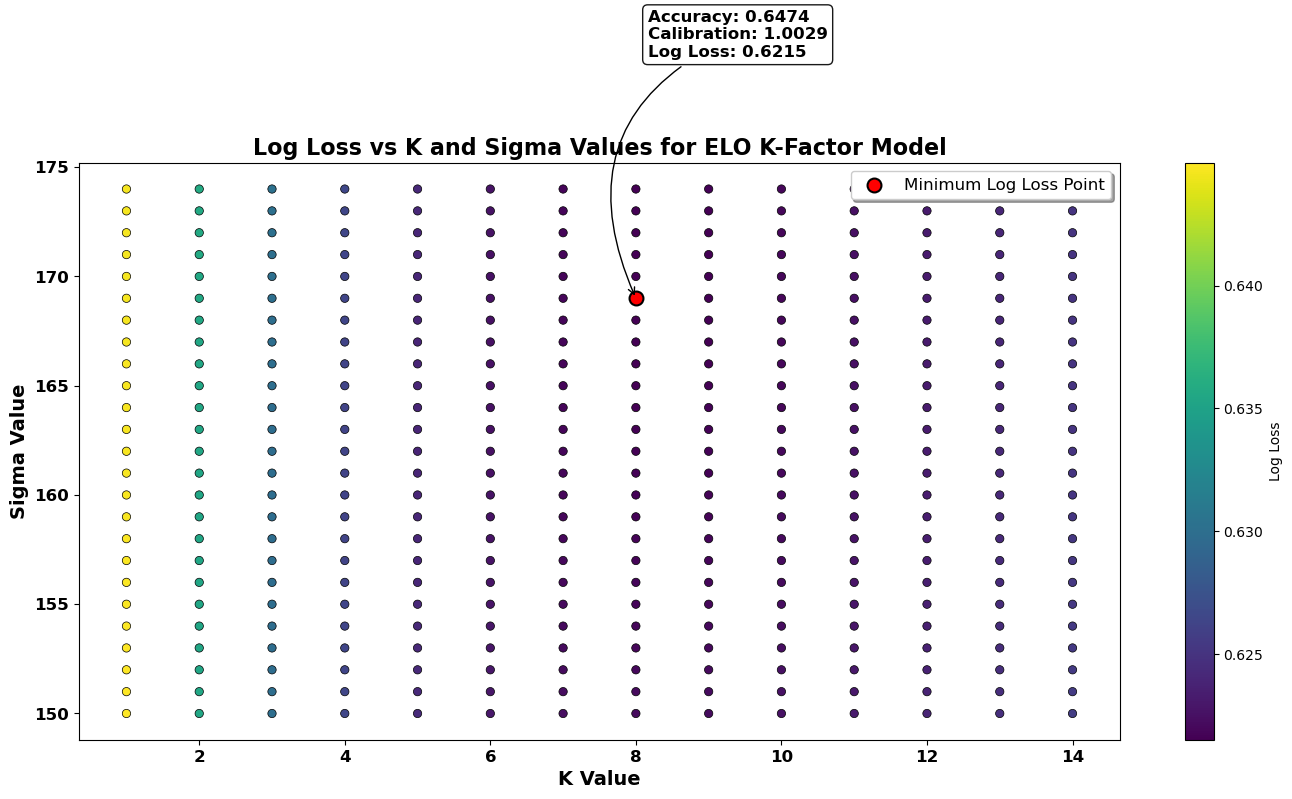

In [17]:
analyze_elo_results(results)

#### For top 50 players

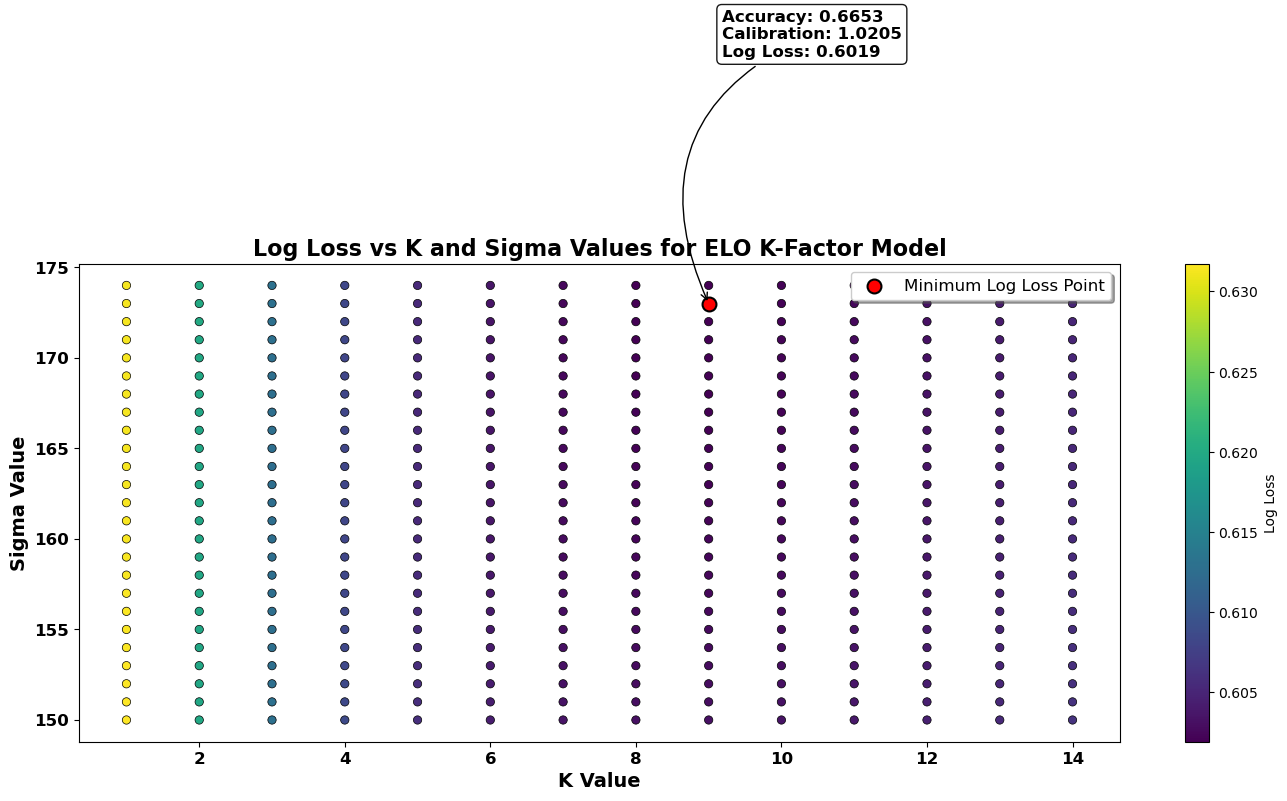

In [18]:
analyze_elo_results(top50_results)

#### For top 100 players

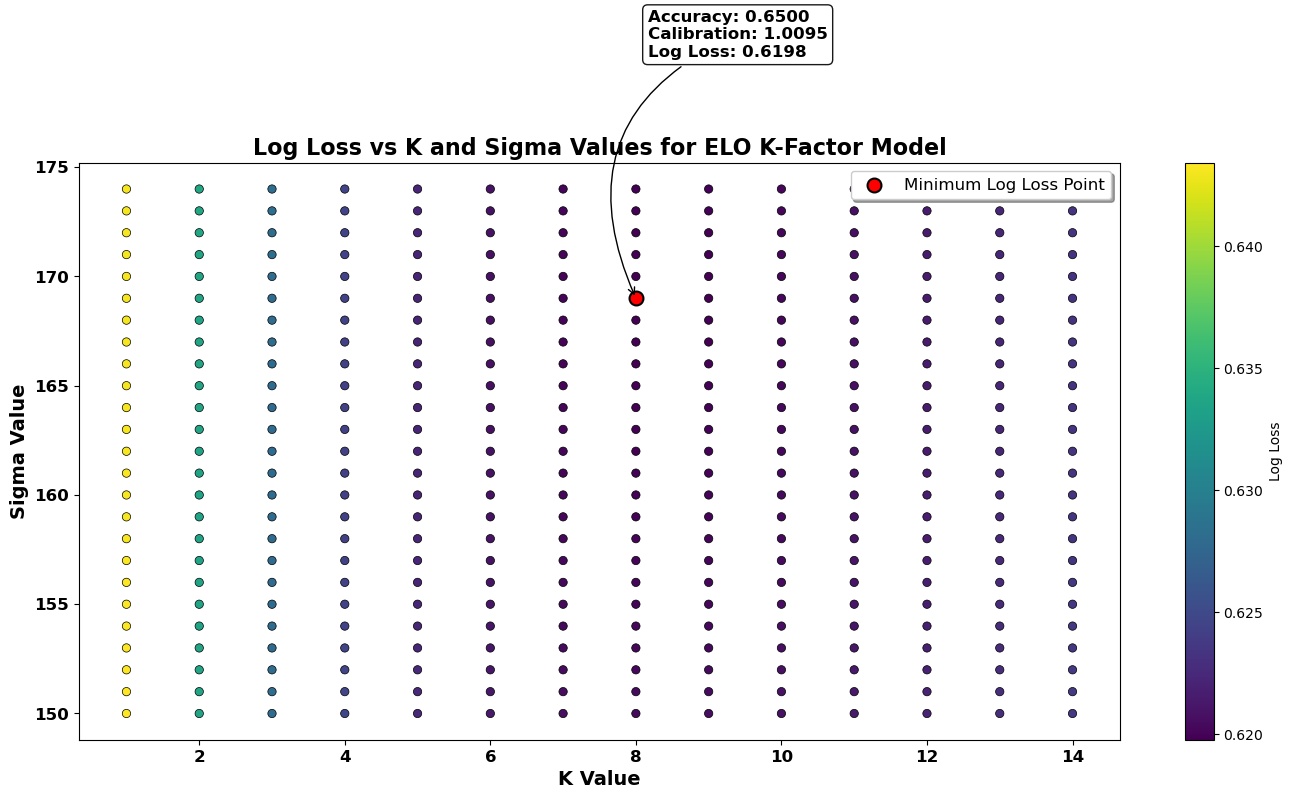

In [19]:
analyze_elo_results(top100_results)

### Best Metrics with minimum log loss for optimal K and Sigma

#### For whole validation set

In [30]:
find_best_log_loss(results)

Best Metrics with Minimum Log Loss:

Accuracy: 0.6474
Calibration: 1.0029
Log Loss: 0.6215


#### For top 50 players

In [29]:
find_best_log_loss(top50_results)

Best Metrics with Minimum Log Loss:

Accuracy: 0.6653
Calibration: 1.0205
Log Loss: 0.6019


#### For top 100 players

In [28]:
find_best_log_loss(top100_results)

Best Metrics with Minimum Log Loss:

Accuracy: 0.6500
Calibration: 1.0095
Log Loss: 0.6198
